In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

input_df = pd.read_csv("data_0505.csv")

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)

     Target
0         0
1         0
2         0
3         1
4         1
..      ...
495       1
496       0
497       0
498       0
499       0

[500 rows x 1 columns]


In [3]:
model_name = 'bert-base-multilingual-uncased'
transformer = text.Transformer(model_name, maxlen=500, class_names= np.array([0,1,2])) #PROVARE CON MAGGIORE MAXLEN

In [4]:
print(type(x_train["Titles"]))
print(x_train.head())

<class 'pandas.core.series.Series'>
                                                Titles
249  Illumina Inc (ILMN) Q1 Earnings: Navigating Th...
433  T-Mobile US, Inc. (NASDAQ:TMUS) Director Telek...
19   Google (NASDAQ:GOOGL) Battles Epic Games Over ...
322  Mohawk Industries (MHK) Q3 Earnings Meet Estim...
332  Cwm LLC Has $191000 Position in Fidelity MSCI ...


In [5]:
y_train = y_train + 1           # VUOLE CLASSI NUMERATE DA 0
y_test = y_test + 1
processed_train = transformer.preprocess_train(list(x_train["Titles"]), list(y_train["Target"]))
processed_test = transformer.preprocess_test(list(x_test["Titles"]), list(y_test["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 1677
	95percentile : 1850
	99percentile : 1893


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1669
	95percentile : 1822
	99percentile : 1926


In [6]:
#for i in y_train.Target:
#    print(i)

In [7]:
#print(x_train.iloc[0])
#print(processed_train.x[0][0])

In [8]:
model = transformer.get_classifier()
batch_size = 5                        #small training dataset
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=batch_size)

In [9]:
print(processed_train.y)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


simulating training for different learning rates... this may take a few moments...
80/80 [==============================] - 946s 12s/step - loss: 47.4888 - accuracy: 0.4692


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\lroptimize\lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Visually inspect loss plot and select learning rate associated with falling loss


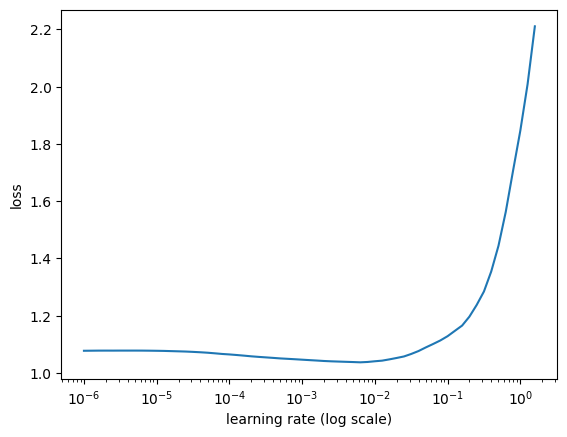

In [10]:
learner.lr_find(show_plot=True,  max_epochs=1)


batch_size = 1 (dumb idea?) \
lr \
1e-4 seems good    val_accuracy : 0.65 (o più di 0.52?)   tempo 2 epoche: 50 minuti \
5e-3               val_accuracy : 0.65 (o 0.49?) tempo 2 epoche 47 minuti \
 \
batch_size = 2 \
provare a cambiare batch size  \
1e-3               val_accuracy : 0.65 (o 0.54)  \
0.5e-4             val_accuracy : 0.65 (o 0.56)                 \

batch_size = 5 \
0.5e-4             val_accuracy : 0.65 (o 0.5375)        75min 4 epoch         \
1e-3

In [12]:
learner.fit_onecycle(1e-3, 2)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/2
80/80 [==============================] - 1119s 14s/step - loss: 1.0215 - accuracy: 0.4875 - val_loss: 0.9977 - val_accuracy: 0.2800
Epoch 2/2
80/80 [==============================] - 1117s 14s/step - loss: 0.9572 - accuracy: 0.5050 - val_loss: 0.8298 - val_accuracy: 0.6500


In [ ]:
learner.validate(class_names=transformer.get_classes())

4/4 [==============================] - 58s 13s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      1.00      0.79        65
           2       0.00      0.00      0.00        28

    accuracy                           0.65       100
   macro avg       0.22      0.33      0.26       100
weighted avg       0.42      0.65      0.51       100



c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0,  7,  0],
       [ 0, 65,  0],
       [ 0, 28,  0]], dtype=int64)

In [66]:
'''
# let's see some predictions
'''
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
import random as rand
i = rand.randint(0,100)

print(input_df["Unnamed: 0"].iloc[i],"\n",\
      "Prediction: \n",\
      predictor.predict(x_test["Titles"].iloc[i]),\
      "\nTarget: \n",\
      y_train["Target"].iloc[i])

CF 
 Prediction: 
 1 
Target: 
 0
